In [19]:
import os
import pickle
import tarfile
import datetime
import zipfile
import urllib.request

import tensorflow as tf
import tensorflow_datasets.public_api as tfds
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import keras

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd
import scipy.io

import sklearn.metrics
from sklearn.neighbors import NearestNeighbors

from PIL import Image
from IPython.display import clear_output

In [20]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 1. Download dataset

In [2]:
zip_path = 'archive.zip'

base_extract_path = 'Flowers Recognition/'

archive_name = os.path.splitext(os.path.basename(zip_path))[0]

extract_path = os.path.join(base_extract_path, archive_name)

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
zip_path = 'tfrecords-jpeg-224x224.zip'

base_extract_path = 'tfrecords/'

archive_name = os.path.splitext(os.path.basename(zip_path))[0]

extract_path = os.path.join(base_extract_path, archive_name)

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:
tar_path = '102flowers.tgz'

base_extract_path = '102flowers/'

archive_name = os.path.splitext(os.path.basename(tar_path))[0]

extract_path = os.path.join(base_extract_path, archive_name)

os.makedirs(extract_path, exist_ok=True)

with tarfile.open(tar_path, 'r:gz') as tar_ref:
    tar_ref.extractall(extract_path)

- Датасет Flowers Recognition - имеет уже собранную структуру с train и val с классами в своих папках  
- Датасет Petals to the Metal (tfrecords-jpeg) - фотографии и метки классов находятся в файлах формата tfrec - необходимо их считать и разбить по папкамм классов  
- Датасет 102 Category Flower - все фотографии находятся в одной папке, классы в отдельном файле, необходимо разбить на подпапки классов и разбить на train и val  

In [2]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',
           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',
           'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',
           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya',
           'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',
           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff', 
           'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',
           'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',
           'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow', 
           'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia', 
           'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose'
]

# Описание структуры данных
feature_description = {
    'id': tf.io.FixedLenFeature([], tf.string),
    'class': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
}

# Функция для парсинга примеров
def _parse_function(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

# Функция для сохранения изображений в папки
def save_images_from_tfrecord(tfrecord_paths, output_dir):
    # Преобразование Dataset в список путей
    tfrecord_paths = list(tfrecord_paths.as_numpy_iterator())
    
    # Чтение TFRecord файлов
    dataset = tf.data.Dataset.from_tensor_slices(tfrecord_paths)
    dataset = dataset.interleave(lambda x: tf.data.TFRecordDataset(x), cycle_length=4)
    dataset = dataset.map(_parse_function)

    # Создание папок, если они не существуют
    os.makedirs(output_dir, exist_ok=True)

    # Проход по данным и сохранение изображений
    for example in dataset:
        image_id = example['id'].numpy().decode('utf-8')
        image = example['image'].numpy()
        label = example['class'].numpy()

        # Декодирование изображения
        image = tf.image.decode_image(image)
        image = Image.fromarray(image.numpy())

        # Создание папки для метки, если она не существует
        label_dir = os.path.join(output_dir, str(CLASSES[label]))
        os.makedirs(label_dir, exist_ok=True)

        # Сохранение изображения
        image_path = os.path.join(label_dir, f'{image_id}.jpg')
        image.save(image_path)

# Пути к TFRecord файлам
train_tfrecord_paths = tf.data.Dataset.list_files('tfrecords/train/*.tfrec')
val_tfrecord_paths = tf.data.Dataset.list_files('tfrecords/val/*.tfrec')
# test_tfrecord_paths = tf.data.Dataset.list_files('tfrecords/test/*.tfrec')

# Пути к выходным папкам
train_output_dir = 'tfrecords/train/'
val_output_dir = 'tfrecords/val/'
# test_output_dir = 'tfrecords/test/'

# Извлечение и сохранение изображений
save_images_from_tfrecord(train_tfrecord_paths, train_output_dir)
save_images_from_tfrecord(val_tfrecord_paths, val_output_dir)
# save_images_from_tfrecord(test_tfrecord_paths, test_output_dir)

2024-08-28 19:29:24.622668: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-28 19:29:24.823579: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-28 19:29:24.823623: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-28 19:29:24.826025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-28 19:29:24.826063: I external/local_xla/xla/stream_executor

In [9]:
mat_data = scipy.io.loadmat('imagelabels.mat')

mat_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
 '__version__': '1.0',
 '__globals__': [],
 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}

In [ ]:
dataset, info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)

2024-09-01 16:37:36.706189: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


/home/dron46/anaconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|                                                                          | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|                                                                          | 0/2 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|                                                                          | 0/3 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|                                                                          | 0/3 [00:01<?, ? url/s]
Dl Size...: 0 MiB [00:01, ? MiB/s]

Dl Completed...:  33%|█████████

In [3]:
_NAMES = [
    "pink primrose",
    "hard-leaved pocket orchid",
    "canterbury bells",
    "sweet pea",
    "english marigold",
    "tiger lily",
    "moon orchid",
    "bird of paradise",
    "monkshood",
    "globe thistle",
    "snapdragon",
    "colt's foot",
    "king protea",
    "spear thistle",
    "yellow iris",
    "globe-flower",
    "purple coneflower",
    "peruvian lily",
    "balloon flower",
    "giant white arum lily",
    "fire lily",
    "pincushion flower",
    "fritillary",
    "red ginger",
    "grape hyacinth",
    "corn poppy",
    "prince of wales feathers",
    "stemless gentian",
    "artichoke",
    "sweet william",
    "carnation",
    "garden phlox",
    "love in the mist",
    "mexican aster",
    "alpine sea holly",
    "ruby-lipped cattleya",
    "cape flower",
    "great masterwort",
    "siam tulip",
    "lenten rose",
    "barbeton daisy",
    "daffodil",
    "sword lily",
    "poinsettia",
    "bolero deep blue",
    "wallflower",
    "marigold",
    "buttercup",
    "oxeye daisy",
    "common dandelion",
    "petunia",
    "wild pansy",
    "primula",
    "sunflower",
    "pelargonium",
    "bishop of llandaff",
    "gaura",
    "geranium",
    "orange dahlia",
    "pink-yellow dahlia?",
    "cautleya spicata",
    "japanese anemone",
    "black-eyed susan",
    "silverbush",
    "californian poppy",
    "osteospermum",
    "spring crocus",
    "bearded iris",
    "windflower",
    "tree poppy",
    "gazania",
    "azalea",
    "water lily",
    "rose",
    "thorn apple",
    "morning glory",
    "passion flower",
    "lotus",
    "toad lily",
    "anthurium",
    "frangipani",
    "clematis",
    "hibiscus",
    "columbine",
    "desert-rose",
    "tree mallow",
    "magnolia",
    "cyclamen",
    "watercress",
    "canna lily",
    "hippeastrum",
    "bee balm",
    "ball moss",
    "foxglove",
    "bougainvillea",
    "camellia",
    "mallow",
    "mexican petunia",
    "bromelia",
    "blanket flower",
    "trumpet creeper",
    "blackberry lily",
]

In [4]:
train_dataset = dataset['train']
test_dataset = dataset['test']
valid_dataset = dataset['validation']

In [5]:
d = iter(train_dataset)

In [13]:
img, l = next(d)

Text(0.5, 1.0, 'gazania')

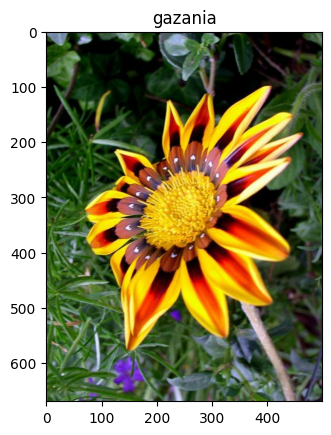

In [14]:
plt.imshow(img)
plt.title(f'{_NAMES[l]}')

In [21]:
output_dir = 'oxford_flowers102_images'
os.makedirs(output_dir, exist_ok=True)

In [22]:
def save_images(dataset, dataset_type, names):
    for image, label in tfds.as_numpy(dataset):
        class_dir = os.path.join(output_dir, dataset_type, str(names[label]))
        os.makedirs(class_dir, exist_ok=True)
        image_path = os.path.join(class_dir, f'{len(os.listdir(class_dir))}.jpg')
        tf.keras.utils.save_img(image_path, image)

In [23]:
save_images(train_dataset, 'train', _NAMES)

2024-09-01 17:20:08.266931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
save_images(test_dataset, 'test', _NAMES)

2024-09-01 17:24:50.767170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
save_images(valid_dataset, 'val', _NAMES)

2024-09-01 17:25:52.193626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
!pip install split-folders

In [40]:
import sys
print(sys.executable)

/home/dron46/anaconda3/envs/tf/bin/python


In [9]:
import splitfolders


input_folder = 'Flowers Recognition/'
output_folder = 'Flowers Recognition split/'


splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(0.8, 0.1, 0.1))

Copying files: 4317 files [06:04, 11.83 files/s]


In [15]:
import os
import shutil


source_folders = [
    'Flowers Recognition split/',
    'tfrecords/',
    'oxford_flowers102_images/'
]


target_folder = 'All_flowers'


os.makedirs(os.path.join(target_folder, 'train'), exist_ok=True)
os.makedirs(os.path.join(target_folder, 'val'), exist_ok=True)


def copy_files(source_dir, target_dir):
    for root, dirs, files in os.walk(source_dir):
        for file in files:

            rel_path = os.path.relpath(root, source_dir)

            target_path = os.path.join(target_dir, rel_path)
            os.makedirs(target_path, exist_ok=True)

            shutil.copy(os.path.join(root, file), os.path.join(target_path, file))


for source_folder in source_folders:
    train_source = os.path.join(source_folder, 'train')
    val_source = os.path.join(source_folder, 'val')
    
    copy_files(train_source, os.path.join(target_folder, 'train'))
    copy_files(val_source, os.path.join(target_folder, 'val'))

print("Объединение завершено.")

Объединение завершено.


# 2. Генерация dataset train и val

In [21]:
def image_dataset_from_directory(
    directory: str,
    image_size: tuple[int, int]=(256, 256),
    batch_size: int = 32,
    shuffle: bool = True,
    seed: int | None = None,
    validation_split: float | None = None,
    subset: str | None = None
) -> tf.data.Dataset:

    def read_image(path: tf.Tensor) -> tf.Tensor:
        img = tf.io.read_file(path)
        img = tf.io.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.convert_image_dtype(img, tf.float32)
        
        img = tf.image.resize_with_pad(img, *image_size)
        return img
        
    if (subset is not None) != (validation_split is not None):
        raise ValueError("If 'subset' is set, 'validation_split' must be set, and inversely.")

    if subset not in {"both", "training", "validation", None}:
        raise ValueError(
            '`subset` must be either "both", "training", "validation", 'f"received: {subset}"
        )

    class_names = []
    paths = []
    labels = []
    for class_name in os.listdir(directory): 
        class_path = os.path.join(directory, class_name)
        
        if not os.path.isdir(class_path):
            continue

        class_label = len(class_names)
        class_names.append(class_name)

        for file in os.listdir(class_path):
            if os.path.isdir(os.path.join(class_path, file)):
                continue
            paths.append(os.path.join(class_path, file))
            labels.append(class_label)
            
    paths = np.array(paths)
    labels = np.array(labels)
    
    if shuffle:   
        if seed is None:
            rng = np.random.default_rng()
            index = rng.choice(len(labels), size=len(labels), replace=False)
            paths = paths[index]
            labels = labels[index]
        else:
            rng = np.random.default_rng(seed)
            index = rng.choice(len(labels), size=len(labels), replace=False)
            paths = paths[index]
            labels = labels[index]

    if validation_split is not None:  
        num_samples = int((1 - validation_split) * len(paths))
        
        if subset == 'both':
            paths_train, labels_train = paths[:num_samples], labels[:num_samples]
            paths_val, labels_val = paths[num_samples:], labels[num_samples:]
            
            train_dataset = tf.data.Dataset.zip(
                tf.data.Dataset.from_tensor_slices(paths_train).map(read_image),
                tf.data.Dataset.from_tensor_slices(labels_train),
            )
            
            train_dataset = train_dataset.batch(batch_size)
            
            val_dataset = tf.data.Dataset.zip(
                tf.data.Dataset.from_tensor_slices(paths_val).map(read_image),
                tf.data.Dataset.from_tensor_slices(labels_val),
            )
            
            val_dataset = val_dataset.batch(batch_size)

            return train_dataset, val_dataset
        else:
            if subset == 'training':
                paths, labels = paths[:num_samples], labels[:num_samples]
            elif subset == 'validation':
                paths, labels = paths[num_samples:], labels[num_samples:]
    
            dataset = tf.data.Dataset.zip(
                tf.data.Dataset.from_tensor_slices(paths).map(read_image),
                tf.data.Dataset.from_tensor_slices(labels),
            )
            
            dataset = dataset.batch(batch_size)
    
            return dataset
            
    else:
        dataset = tf.data.Dataset.zip(
            tf.data.Dataset.from_tensor_slices(paths).map(read_image),
            tf.data.Dataset.from_tensor_slices(labels),
        )
            
        dataset = dataset.batch(batch_size)
    
        return dataset, class_names

In [22]:
train_dataset, train_names = image_dataset_from_directory('All_flowers//train', image_size=(224, 224), batch_size=32, shuffle=True, seed=13)

In [5]:
iterr = iter(train_dataset)

In [6]:
img, label  = next(iterr)
label

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([ 38,  94,  97, 104,  57,  88,  75,  49,  95,  70,  32,  32, 106,
        66,  25, 103,  42,  41,  73, 108,  75,  94,   0,  64,  43,  84,
        32,  55,  33,  21,  69,  27])>

In [7]:
train_names

['alpine sea holly',
 'anthurium',
 'artichoke',
 'azalea',
 'balloon flower',
 'barberton daisy',
 'bearded iris',
 'bee balm',
 'bird of paradise',
 'bishop of llandaff',
 'black-eyed susan',
 'blackberry lily',
 'blanket flower',
 'bolero deep blue',
 'bougainvillea',
 'bromelia',
 'buttercup',
 'californian poppy',
 'camellia',
 'canna lily',
 'canterbury bells',
 'cape flower',
 'carnation',
 'cautleya spicata',
 'clematis',
 "colt's foot",
 'columbine',
 'corn poppy',
 'cosmos',
 'cyclamen',
 'cyclamen ',
 'daffodil',
 'dandelion',
 'desert-rose',
 'english marigold',
 'fire lily',
 'foxglove',
 'frangipani',
 'fritillary',
 'garden phlox',
 'gaura',
 'gazania',
 'geranium',
 'giant white arum lily',
 'globe thistle',
 'globe-flower',
 'grape hyacinth',
 'great masterwort',
 'hard-leaved pocket orchid',
 'hibiscus',
 'hippeastrum',
 'hippeastrum ',
 'iris',
 'japanese anemone',
 'king protea',
 'lenten rose',
 'lilac hibiscus',
 'lotus',
 'love in the mist',
 'magnolia',
 'mallow

Text(0.5, 1.0, 'fritillary')

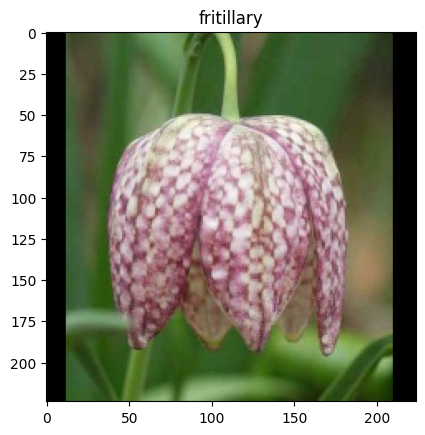

In [8]:
plt.imshow(img[0])
plt.title(f'{train_names[label[0]]}')

In [23]:
val_dataset, val_names = image_dataset_from_directory('All_flowers//val', image_size=(224, 224), batch_size=32, shuffle=True, seed=13)

In [10]:
iterr_val = iter(val_dataset)

In [11]:
img_val, label_val  = next(iterr_val)
label_val

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([  2,  16, 102,  44,  30,  34,  99,  26,  21,  57,   1,  84,  27,
        11,  75,  23, 108, 108,  34, 106,  94,  84,  84, 106,  60,  11,
        15,  96,  84,   4,  18,  57])>

In [12]:
val_names

['alpine sea holly',
 'anthurium',
 'artichoke',
 'azalea',
 'balloon flower',
 'barberton daisy',
 'bearded iris',
 'bee balm',
 'bird of paradise',
 'bishop of llandaff',
 'black-eyed susan',
 'blackberry lily',
 'blanket flower',
 'bolero deep blue',
 'bougainvillea',
 'bromelia',
 'buttercup',
 'californian poppy',
 'camellia',
 'canna lily',
 'canterbury bells',
 'cape flower',
 'carnation',
 'cautleya spicata',
 'clematis',
 "colt's foot",
 'columbine',
 'corn poppy',
 'cosmos',
 'cyclamen',
 'cyclamen ',
 'daffodil',
 'dandelion',
 'desert-rose',
 'english marigold',
 'fire lily',
 'foxglove',
 'frangipani',
 'fritillary',
 'garden phlox',
 'gaura',
 'gazania',
 'geranium',
 'giant white arum lily',
 'globe thistle',
 'globe-flower',
 'grape hyacinth',
 'great masterwort',
 'hard-leaved pocket orchid',
 'hibiscus',
 'hippeastrum',
 'hippeastrum ',
 'iris',
 'japanese anemone',
 'king protea',
 'lenten rose',
 'lilac hibiscus',
 'lotus',
 'love in the mist',
 'magnolia',
 'mallow

Text(0.5, 1.0, 'artichoke')

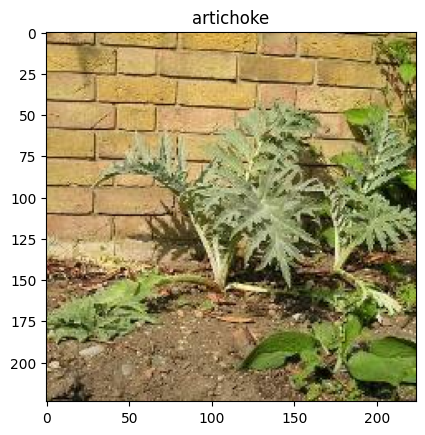

In [13]:
plt.imshow(img_val[0])
plt.title(f'{val_names[label_val[0]]}')

# 3. Создание моделей, их обучение и тестирование

## 3.1. Модель свертки построенная самостоятельно

In [6]:
initializer = tf.keras.initializers.HeNormal()

inputs = tf.keras.layers.Input((224, 224, 3), dtype=tf.float32, name="inputs")
input_norm = tf.keras.layers.BatchNormalization(name='b0')(inputs)


x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=initializer, name='conv1')(input_norm)
x = tf.keras.layers.BatchNormalization(name=f'bn_1')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=initializer, name='conv2')(x)
x = tf.keras.layers.BatchNormalization(name=f'bn_2')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
x = tf.keras.layers.Dropout(0.3, name='drop1')(x)

x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=initializer, name='conv3')(x)
x = tf.keras.layers.BatchNormalization(name=f'bn_3')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=initializer, name='conv4')(x)
x = tf.keras.layers.BatchNormalization(name=f'bn_4')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
x = tf.keras.layers.Dropout(0.5, name='drop2')(x)

x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer=initializer, name='conv5')(x)
x = tf.keras.layers.BatchNormalization(name=f'bn_5')(x)
x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer=initializer, name='conv6')(x)
x = tf.keras.layers.BatchNormalization(name=f'bn_6')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool3')(x)

x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer=initializer, name='conv7')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer=initializer, name='conv8')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool4')(x)

x = tf.keras.layers.Flatten(name='flatten1')(x)
x = tf.keras.layers.Dense(512, kernel_initializer=initializer, activation='relu', name='danse1')(x)
x = tf.keras.layers.BatchNormalization(name='bn1')(x)
x = tf.keras.layers.Dropout(0.5, name='drop3')(x)
x = tf.keras.layers.Dense(200, kernel_initializer=tf.keras.initializers.GlorotUniform(), name='danse2')(x)

model = tf.keras.Model(inputs=inputs, outputs=x, name='conv_img')

In [7]:
model.summary()

Model: "conv_img"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b0 (BatchNormalization)         │ (None, 224, 224, 3)    │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 224, 224, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 224, 224, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 112, 112, 128)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 112, 112, 128)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_5 (BatchNormalization)       │ (None, 56, 56, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_6 (BatchNormalization)       │ (None, 56, 56, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv8 (Conv2D)                  │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten1 (Flatten)              │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ danse1 (Dense)                  │ (None, 512)            │     6,423,04

 Total params: 8,856,852 (33.79 MB)

 Trainable params: 8,854,030 (33.78 MB)

 Non-trainable params: 2,822 (11.02 KB)

In [8]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [19]:
%load_ext tensorboard

In [20]:
HISTORY_DIR = './history'
os.makedirs(HISTORY_DIR, exist_ok=True)

In [21]:
logdir = os.path.join(HISTORY_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [22]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(logdir, 'model.keras'),
    save_best_only=True
)

In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    os.path.join(logdir, 'logs'),    
)

In [24]:
model.fit(train_dataset, validation_data=val_dataset, batch_size=32, epochs=20, callbacks=[model_checkpoint_callback, tensorboard_callback])

Epoch 1/20


I0000 00:00:1725363642.186432   47704 service.cc:145] XLA service 0x7fb3800034e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725363642.186487   47704 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-09-03 21:40:42.279302: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-03 21:40:42.652635: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1725363672.991254   47704 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


699/699 ━━━━━━━━━━━━━━━━━━━━ 232s 284ms/step - accuracy: 0.1327 - loss: 4.1133 - val_accuracy: 0.2226 - val_loss: 3.1462
Epoch 2/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 172s 245ms/step - accuracy: 0.2348 - loss: 3.0721 - val_accuracy: 0.2493 - val_loss: 2.9856
Epoch 3/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 173s 248ms/step - accuracy: 0.2777 - loss: 2.8271 - val_accuracy: 0.3076 - val_loss: 2.6769
Epoch 4/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 173s 247ms/step - accuracy: 0.3452 - loss: 2.5522 - val_accuracy: 0.3555 - val_loss: 2.4334
Epoch 5/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 172s 246ms/step - accuracy: 0.4005 - loss: 2.3025 - val_accuracy: 0.3692 - val_loss: 3.3779
Epoch 6/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 172s 246ms/step - accuracy: 0.4572 - loss: 2.0505 - val_accuracy: 0.4862 - val_loss: 5.0144
Epoch 7/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 172s 246ms/step - accuracy: 0.5078 - loss: 1.7964 - val_accuracy: 0.5126 - val_loss: 1.9704
Epoch 8/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 173s 248ms/step - accuracy: 0.4798 - loss: 1.96

In [17]:
model.evaluate(val_dataset)

162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6422 - loss: 1.7974


[1.7953124046325684, 0.6383184790611267]

In [48]:
model.save_weights('weights_conv.weights.h5')

In [27]:
y_true = np.concatenate([y for x, y in val_dataset], axis=0)
y_pred = model.predict(val_dataset).argmax(axis=-1)

2024-09-03 22:49:51.211894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


162/162 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step


In [28]:
_, ax = plt.subplots(figsize=(75, 75))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, colorbar=False)

plt.tight_layout()
# plt.savefig('valid.png')

In [14]:
model.save('conv_model.keras')

In [24]:
model = load_model('conv_model.keras')

/home/dron46/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 74 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [25]:
model.summary()

Model: "conv_img"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b0 (BatchNormalization)         │ (None, 224, 224, 3)    │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 224, 224, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 224, 224, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 112, 112, 128)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 112, 112, 128)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_5 (BatchNormalization)       │ (None, 56, 56, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_6 (BatchNormalization)       │ (None, 56, 56, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv8 (Conv2D)                  │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten1 (Flatten)              │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ danse1 (Dense)                  │ (None, 512)            │     6,423,04

 Total params: 26,564,914 (101.34 MB)

 Trainable params: 8,854,030 (33.78 MB)

 Non-trainable params: 2,822 (11.02 KB)

 Optimizer params: 17,708,062 (67.55 MB)

In [26]:
model.input_shape

(None, 224, 224, 3)

#### 3.1.1 Получение похожих цветов, как первых самых вероятных классов

In [10]:
model.load_weights('weights_conv.weights.h5')

/home/dron46/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


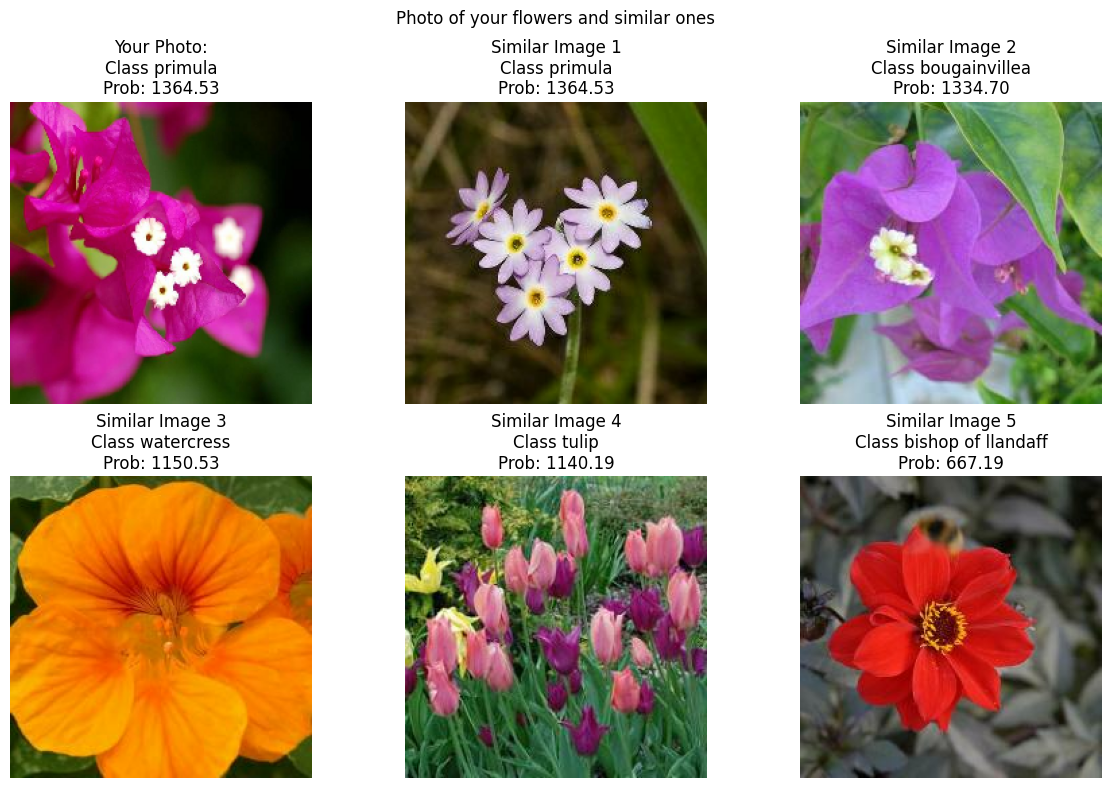

In [66]:
img_path = 'All_flowers/val/bougainvillea/1.jpg'

img = image.load_img(img_path, target_size=(224, 224))  
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  
img_array = tf.image.convert_image_dtype(img_array, tf.float32)

y_pred = model.predict(img_array)
predicted_class = np.argmax(y_pred, axis=1)[0]

def plot_images(images, titles, rows=2, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    plt.suptitle('Photo of your flowers and similar ones')
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()


images = []
titles = []
images.append(img)
titles.append(f'Your Photo:\nClass {val_names[predicted_class]}\nProb: {y_pred[0][predicted_class]:.2f}')

top_k = 5
top_k_idx = np.argsort(y_pred[0])[-top_k:][::-1]
top_k_prob = y_pred[0][top_k_idx]


for idx, (class_idx, prob) in enumerate(zip(top_k_idx, top_k_prob)):
    for batch in val_dataset.as_numpy_iterator():
        imgs, labels = batch
        for img, label in zip(imgs, labels):
            if label == class_idx:
                images.append(img)
                titles.append(f'Similar Image {idx+1}\nClass {val_names[class_idx]}\nProb: {prob:.2f}')
                break
        if len(images) == idx + 2:
            break


plot_images(images, titles)

In [72]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

#### 3.1.2 Поиск похожих изображений за счёт извлечения признаков из фотографий и расчёта косинусного расстояния между ними

In [43]:
model.layers[-6].output

<KerasTensor shape=(None, 7, 7, 256), dtype=float32, sparse=False, name=keras_tensor_21>

In [56]:
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-6].output)

def extract_features(image):
    image = np.expand_dims(image, axis=0)  
    features = feature_extractor(image)
    return features.numpy().squeeze()


features_dataset = []
images_dataset = []  
labels_dataset = []  

for images, labels in val_dataset:  
    for image, label in zip(images, labels):
        features = extract_features(image)
        features_dataset.append(features)
        images_dataset.append(image.numpy())  
        labels_dataset.append(label.numpy())  

features_dataset = np.array([features.flatten() for features in features_dataset])

2024-09-08 17:57:11.039274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


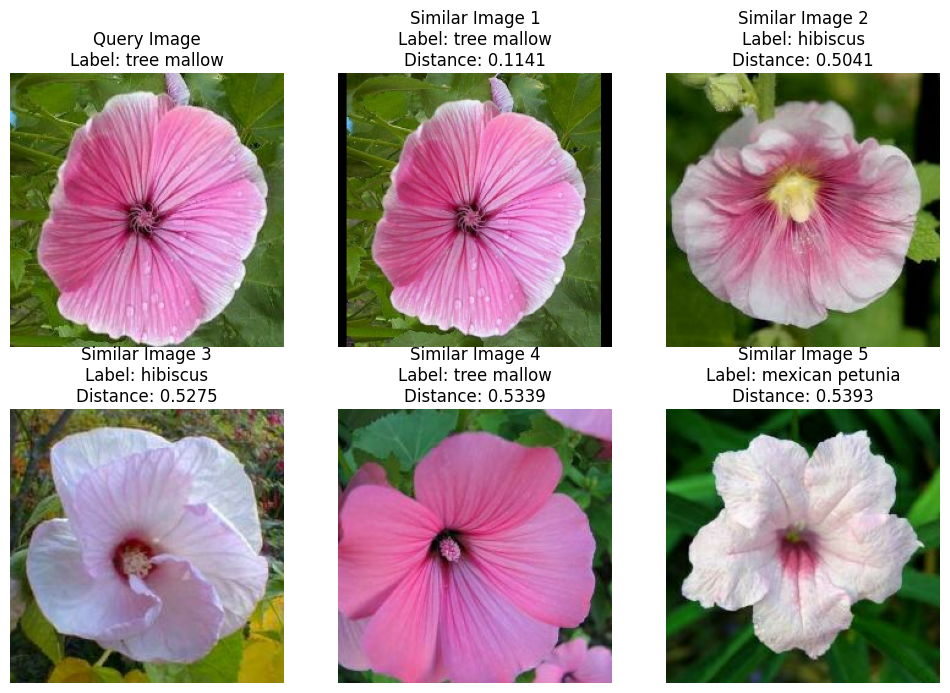

In [61]:
def cosine_distance(vec1, vec2):
    return 1 - np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


def find_similar_images(query_image, features_dataset):
    query_features = extract_features(query_image)
    query_features = query_features.flatten()
    distances = [cosine_distance(query_features, features) for features in features_dataset]
    sorted_indices = np.argsort(distances)
    return sorted_indices, distances


query_image = images_dataset[6] 
query_label = labels_dataset[6]  
sorted_idx, distances = find_similar_images(query_image, features_dataset)

filtered_indices = [idx for idx in sorted_idx if distances[idx] > 0]

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.title(f'Query Image\nClass: {val_names[query_label]}')
plt.imshow(query_image)
plt.axis('off')

for i, idx in enumerate(filtered_indices[:5]):
    similar_image = images_dataset[idx]
    similar_label = labels_dataset[idx]
    plt.subplot(2, 3, i + 2)
    plt.title(f'Similar Image {i+1}\nClass: {val_names[similar_label]}\nDistance: {distances[idx]:.4f}')
    plt.imshow(similar_image)
    plt.axis('off')

plt.show()

#### 3.1.3 Поиск похожих изображений за счёт извлечения признаков из фотографий и модели NearestNeighbors

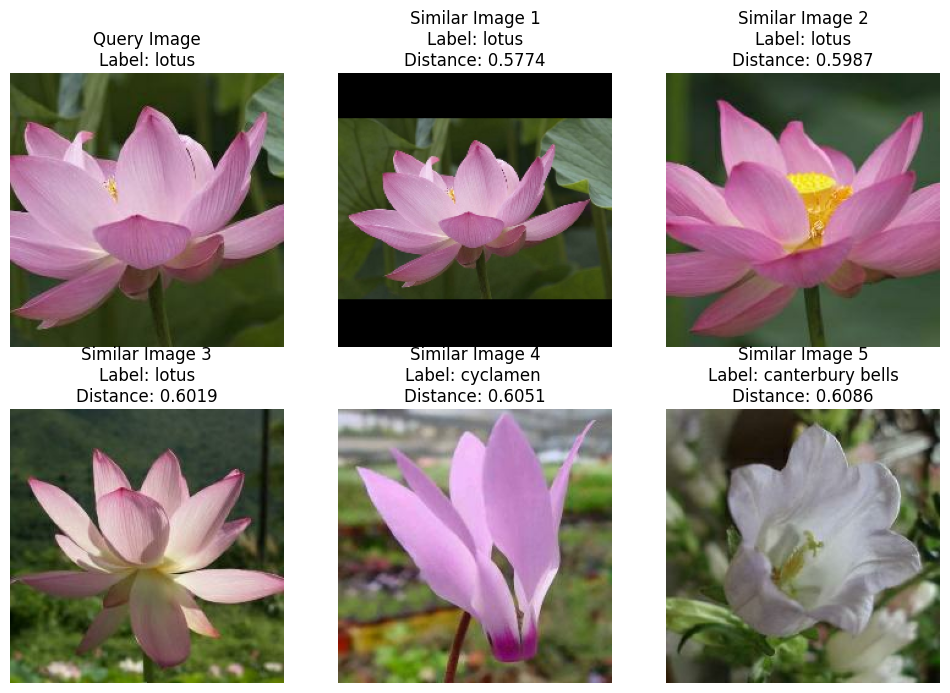

In [59]:
nn_model = NearestNeighbors(n_neighbors=6, metric='cosine')
nn_model.fit(features_dataset)

def find_similar_images(query_image, nn_model, features_dataset):
    query_features = extract_features(query_image)
    query_features = query_features.flatten()
    distances, idx = nn_model.kneighbors([query_features])
    return distances, idx
    
query_image = images_dataset[9]  
query_label = labels_dataset[9]  
distances, similar_images_idx = find_similar_images(query_image, nn_model, features_dataset)

filtered_distances = []
filtered_idx = []
for dist, idx in zip(distances[0], similar_images_idx[0]):
    if dist > 0.0005:  
        filtered_distances.append(dist)
        filtered_idx.append(idx)

plt.figure(figsize=(12, 8))


plt.subplot(2, 3, 1)
plt.title(f'Query Image\nClass: {val_names[query_label]}')
plt.imshow(query_image)
plt.axis('off')

for i, (idx, dist) in enumerate(zip(filtered_idx, filtered_distances)):
    similar_image = images_dataset[idx]
    similar_label = labels_dataset[idx]
    plt.subplot(2, 3, i + 2)
    plt.title(f'Similar Image {i+1}\nClass: {val_names[similar_label]}\nDistance: {dist:.4f}')
    plt.imshow(similar_image)
    plt.axis('off')

plt.show()